In [2]:
import torch
from torchvision import transforms, utils
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
import numpy as np
import torch.nn as nn
from torchinfo import summary


In [3]:
path = './MURA-v1.1/'
train_image_paths_csv = "train_image_paths.csv"
df_train_images_paths = pd.read_csv(os.path.join(path,train_image_paths_csv),dtype=str,header=None)
df_train_images_paths.columns = ['image_path']

In [4]:
df_train_images_paths['label'] = df_train_images_paths['image_path'].map(lambda x: 'positive' if 'positive' in x else 'negative')
df_train_images_paths['category'] = df_train_images_paths['image_path'].apply(lambda x: x.split('/')[2])
#df_train_images_paths['patientId'] = df_train_images_paths['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))

In [5]:
valid_image_paths_csv = "valid_image_paths.csv"
df_valid_data_paths = pd.read_csv(os.path.join(path,valid_image_paths_csv),dtype=str,header=None)
df_valid_data_paths.columns = ['image_path']

In [6]:
df_valid_data_paths['label'] = df_valid_data_paths['image_path'].map(lambda x:'positive' if 'positive' in x else 'negative')
df_valid_data_paths['category']  = df_valid_data_paths['image_path'].apply(lambda x: x.split('/')[2])
#df_valid_data_paths['dir'] =  df_valid_data_paths['image_path'].apply(lambda x: x.split('/')[1])
#df_valid_data_paths['patientId']  = df_valid_data_paths['image_path'].apply(lambda x: x.split('/')[3].replace('patient',''))

In [7]:
df_train_images_paths["label"] = df_train_images_paths["label"].replace({'positive': 1, 'negative': 0})


In [8]:
df_valid_data_paths["label"] = df_valid_data_paths["label"].replace({'positive': 1, 'negative': 0})


# The Model

In [9]:
densenet = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121')

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to C:\Users\Hamad/.cache\torch\hub\v0.10.0.zip


In [10]:
from skimage.filters import butterworth
from skimage.filters import gaussian
from skimage import exposure

In [11]:
from torch.utils.data import Dataset
from skimage import img_as_ubyte
from skimage.color import rgb2gray
class MuraDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None, device='cpu'):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
        self.device = device

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.item()
        
        img_path = self.image_paths[idx]
        image = Image.open(img_path)
        image = image.convert('RGB')
        
        # Convert PIL Image to numpy array
        image_np = np.array(image)
        
        image_gray = rgb2gray(image_np)
        
        # Apply adaptive histogram equalization
        image_gray = exposure.equalize_adapthist(image_gray, clip_limit=0.02)

        
        # Apply Butterworth filter
        image_butterworth = butterworth(image_gray)

        
        # Apply Gaussian filter
        image_gaussian = gaussian(image_gray)
        
        # Combine the two images into one (stack them along the last axis)
        # Create a 3 channel image from the butterworth and gaussian filtered images
        image_combined = np.stack([image_butterworth, image_gaussian, image_gray], axis=-1)
        
        image_combined = (image_combined - np.min(image_combined)) / (np.max(image_combined) - np.min(image_combined))
        
        # Convert to 8-bit image for PIL
        image_combined = img_as_ubyte(image_combined)
        
        # Convert numpy array back to PIL Image
        image = Image.fromarray(image_combined)
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        image = image.to(self.device)
        
        label = torch.tensor(label).to(self.device)

        return image, label


In [12]:
train_label_counts = df_train_images_paths["label"].value_counts()
valid_label_counts = df_valid_data_paths["label"].value_counts()

print("Training Labels Counts:\n", train_label_counts)
print("\nValidation Labels Counts:\n", valid_label_counts)


Training Labels Counts:
 label
0    21935
1    14873
Name: count, dtype: int64

Validation Labels Counts:
 label
0    1667
1    1530
Name: count, dtype: int64


## We noticed some unbalance data so we down sampled it 

In [13]:
# Sampling 
negative_class = df_train_images_paths[ df_train_images_paths['label'] == 0]
postive_class = df_train_images_paths[ df_train_images_paths['label'] == 1]
equal_train_split_negative = negative_class.sample(n=len(postive_class), random_state=62)

In [14]:
len(equal_train_split_negative)

14873

In [15]:
balanced_df = pd.concat([equal_train_split_negative,postive_class],axis=0)

In [16]:
len(df_train_images_paths)

36808

In [17]:
len(balanced_df)

29746

In [18]:
train_balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [19]:
from torch.utils.data import DataLoader
from torchvision.transforms import v2

batchsize = 16
transform = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),  # Already included
    v2.RandomVerticalFlip(p=0.5),  # New: vertical flip
    v2.RandomRotation(10),  # New: random rotation with a maximum rotation angle of 10 degrees
    v2.Resize((224, 224)),  # Already included
    v2.ToTensor(),  # Already included
])


val_transform = v2.Compose([
    v2.Resize((224, 224)),
    v2.ToTensor(),
])

Mura_transform = MuraDataset(train_balanced_df["image_path"], train_balanced_df["label"], transform=transform,device='cuda')
train_loader = DataLoader(Mura_transform, batch_size=batchsize, shuffle=True)
Mura_transform_valid = MuraDataset(df_valid_data_paths["image_path"], df_valid_data_paths["label"], transform=val_transform,device='cuda')
valid_loader = DataLoader(Mura_transform_valid, batch_size=batchsize)



c:\Users\Hamad\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\Hamad\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedba

Feature batch shape: torch.Size([16, 3, 224, 224])
Labels batch shape: torch.Size([16])


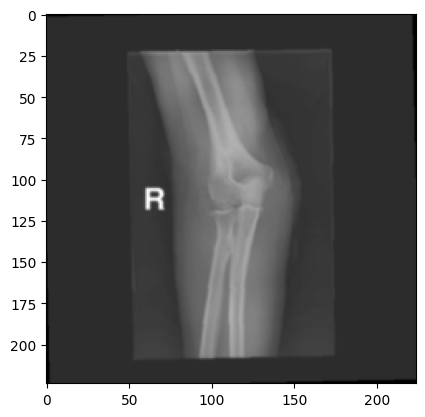

Label: 1


In [20]:
# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

# Select a single image from the batch.
img = train_features[0]

# Select one channel (e.g., the first channel).
img_channel1 = img[1].cpu().numpy()

# Display the selected channel.
plt.imshow(img_channel1, cmap="gray")
plt.show()

# Alternatively, you can display the second channel
# img_channel2 = img[1].cpu().numpy()
# plt.imshow(img_channel2, cmap="gray")
# plt.show()

label = train_labels[0]
print(f"Label: {label}")


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [22]:
summary(densenet, input_size=(16, 3, 224, 224))


Layer (type:depth-idx)                   Output Shape              Param #
DenseNet                                 [16, 1000]                --
├─Sequential: 1-1                        [16, 1024, 7, 7]          --
│    └─Conv2d: 2-1                       [16, 64, 112, 112]        9,408
│    └─BatchNorm2d: 2-2                  [16, 64, 112, 112]        128
│    └─ReLU: 2-3                         [16, 64, 112, 112]        --
│    └─MaxPool2d: 2-4                    [16, 64, 56, 56]          --
│    └─_DenseBlock: 2-5                  [16, 256, 56, 56]         --
│    │    └─_DenseLayer: 3-1             [16, 32, 56, 56]          45,440
│    │    └─_DenseLayer: 3-2             [16, 32, 56, 56]          49,600
│    │    └─_DenseLayer: 3-3             [16, 32, 56, 56]          53,760
│    │    └─_DenseLayer: 3-4             [16, 32, 56, 56]          57,920
│    │    └─_DenseLayer: 3-5             [16, 32, 56, 56]          62,080
│    │    └─_DenseLayer: 3-6             [16, 32, 56, 56]    

In [23]:
print(densenet)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [24]:
num_features = densenet.classifier.in_features
densenet.classifier = nn.Linear(num_features, 2)


In [25]:
print(densenet)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [26]:
densenet.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [27]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet.parameters(), lr=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

In [29]:
num_epochs = 3
for epoch in range(num_epochs):
    densenet.train()
    total_loss = 0.0
    correct = 0  # To keep track of correct predictions
    total = 0  # To keep track of total predictions

    batch_accuracies = []  # To store batch accuracies for the epoch

    for batch_idx, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = densenet(images)

        loss = criterion(outputs, labels) 
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        
        _, predicted = outputs.max(1)  # Get the index of the max log-probability
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Print loss and accuracy for every 100 batches
        if (batch_idx + 1) % 100 == 0:
            batch_accuracy = 100. * correct / total
            batch_accuracies.append(batch_accuracy)  # Store the batch accuracy
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Batch Loss: {loss.item():.4f}, Batch Accuracy: {batch_accuracy:.2f}%")
    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    epoch_accuracy = 100. * correct / total  # Convert to percentage

    # Calculate the average of batch accuracies for the epoch
    avg_batch_accuracy = sum(batch_accuracies) / len(batch_accuracies) if batch_accuracies else 0.0

    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}, Epoch Accuracy: {epoch_accuracy:.2f}%, Average Batch Accuracy: {avg_batch_accuracy:.2f}%")


c:\Users\Hamad\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\optimizer.py:243: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  if not is_compiling() and torch.has_cuda and torch.cuda.is_available():


Epoch [1/3], Batch [100/1860], Batch Loss: 0.6312, Batch Accuracy: 54.69%
Epoch [1/3], Batch [200/1860], Batch Loss: 0.8385, Batch Accuracy: 56.19%


KeyboardInterrupt: 